In [1]:
import os
import sys
import pprint

base_dir = 'F:\Thesis_ssd\MasterThesis3.0'
os.chdir(base_dir)

from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.DataProcessing.TimeAugmentor import TimeAugmentor
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.RandomGridSearchDynamic import RandomGridSearchDynamic
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Modeling.ResultFitter import ResultFitter
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter
import json

helper = HelperFunctions()
%load_ext tensorboard

In [2]:
### Data conditions: ###
load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : True,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 0.4,
    'seed' : 1,
    'subsample_size' : 0.2,
    'balance_non_train_set' : True,
    'use_true_test_set' : False
}

loadData = LoadData(**load_args)

full_ds, train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)
dataGen = DataGenerator(loadData)

if load_args['earth_explo_only']:
    full_and_noise_ds = np.concatenate((full_ds, noise_ds))
    timeAug = TimeAugmentor(handler, full_and_noise_ds, seed = load_args['seed'])
else:
    timeAug = TimeAugmentor(handler, full_ds, seed = load_args['seed'])

In [3]:
print(len(train_ds), len(val_ds), len(test_ds))
classes, counts = handler.get_class_distribution_from_ds(full_ds)
classes, counts = handler.get_class_distribution_from_ds(train_ds)
classes, counts = handler.get_class_distribution_from_ds(val_ds)
print("Nr noise samples " + str(len(loadData.noise_ds)))

24089 2125 2126
Total: 28340, earthquake: 9548, explosion: 9213, noise: 9579
Total: 24089, earthquake: 8104, explosion: 7844, noise: 8141
Total: 2125, earthquake: 757, explosion: 694, noise: 674
Nr noise samples 8141


In [4]:
print(len(set(loadData.label_dict.values())))

2


In [5]:
hyper_grid = {
        "num_layers" : [2,4,5,6],
        "batch_size" : [64, 128, 256, 512],
        "epochs" : [30, 33, 35],
        "learning_rate" : [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "optimizer" : ["adam", "rmsprop", "sgd"]
    }
# Note that len(decay_sequence_i) must be equal to max(num_layers)
model_grid = {
    "start_neurons" : [16, 32, 64, 128, 256, 512, 1024],
    "decay_sequence" : [[1,2,4,6,8,10], [1,2,4,4,2,1], [1,4,8,8,4,1], [1,0.5,0.25,0.25,0.5,1], [1,1,1,1,1,1]],
    "dropout_rate" : [0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001, 0],
    "filters" : [11, 13, 15, 17, 19, 21, 23, 25, 27],
    "kernel_size" : [3, 5, 7, 9, 11, 13, 15],
    "padding" : ["same"],
    "l2_r" : [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    "l1_r" : [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    "activation" : ["relu", "sigmoid", "softmax", "tanh"],
    "output_layer_activation" : ["sigmoid"]
}


model_type = "CNN"

use_time_augmentor = True
use_scaler = True
use_noise_augmentor = True
detrend = False
use_minmax = True
use_highpass = False
highpass_freq = 0.1

n_picks = 10

use_tensorboard = False
use_liveplots = True
use_custom_callback = False
use_early_stopping = True
start_from_scratch = True

randomGridSearch = RandomGridSearchDynamic(loadData, train_ds, val_ds, test_ds, model_type, detrend, use_scaler, use_time_augmentor, 
                                    use_noise_augmentor, use_minmax, use_highpass, n_picks, hyper_grid = hyper_grid, 
                                    model_grid = model_grid, use_tensorboard = use_tensorboard,
                                    use_liveplots = use_liveplots, use_custom_callback = use_custom_callback,
                                    use_early_stopping = use_early_stopping, highpass_freq = highpass_freq,
                                    start_from_scratch = start_from_scratch)

In [6]:
def clear_tensorboard_dir():
    import os
    import shutil
    path = f"{base_dir}/Tensorboard_dir/fit"
    files = os.listdir(path)
    print(files)
    for f in files:
        shutil.rmtree(os.path.join(path,f))
if use_tensorboard:
    clear_tensorboard_dir()
    %tensorboard --logdir tensorboard_dir/fit

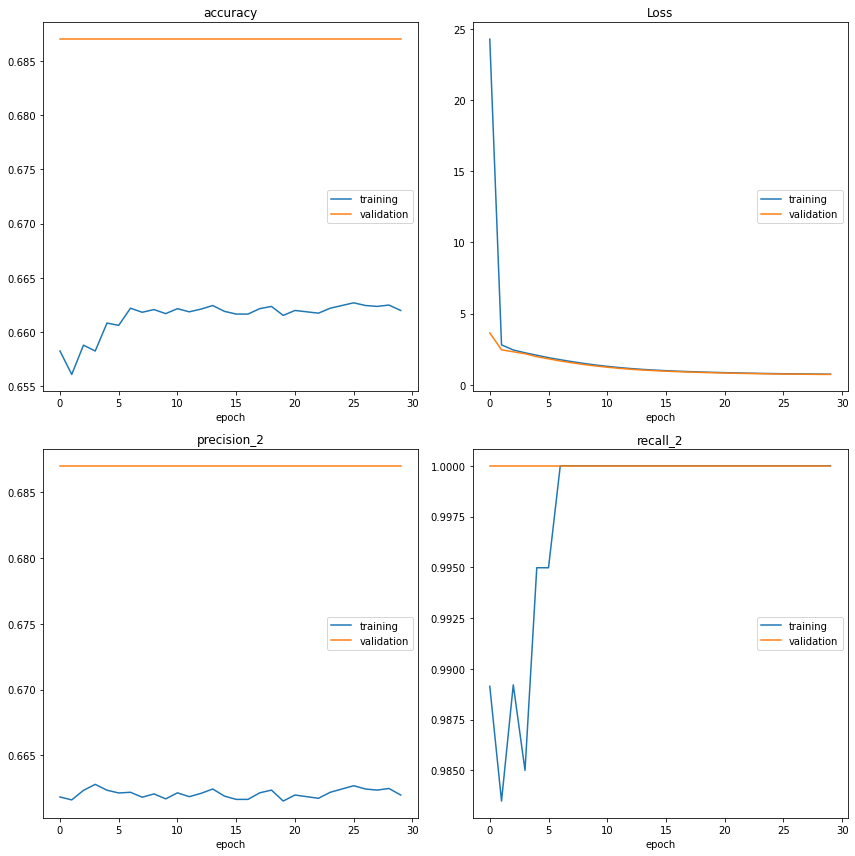

accuracy
	training         	 (min:    0.656, max:    0.663, cur:    0.662)
	validation       	 (min:    0.687, max:    0.687, cur:    0.687)
Loss
	training         	 (min:    0.745, max:   24.287, cur:    0.745)
	validation       	 (min:    0.726, max:    3.645, cur:    0.726)
precision_2
	training         	 (min:    0.662, max:    0.663, cur:    0.662)
	validation       	 (min:    0.687, max:    0.687, cur:    0.687)
recall_2
	training         	 (min:    0.983, max:    1.000, cur:    1.000)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)
188/188 [==============================] - 60s 318ms/step - loss: 0.7447 - precision_2: 0.6620 - accuracy: 0.6620 - recall_2: 1.0000 - val_loss: 0.7257 - val_precision_2: 0.6870 - val_accuracy: 0.6870 - val_recall_2: 1.0000
[{'model_nr_type': 'CNN', 'index': 3}, {'batch_size': 512, 'epochs': 30, 'learning_rate': 0.1, 'num_layers': 5, 'optimizer': 'adam'}, {'activation': 'softmax', 'decay_sequence': [1, 2, 4, 4, 2], 'dropout_rate': 0.

In [ ]:
results_df, min_loss, max_accuracy, max_precision, max_recall = randomGridSearch.fit()